# Starting point
In `3. Handwritten Digits - Dimensionality Reduction` I laborated with PCA dimensionality reduction on the MNIST data set, and evaluated performance of a KNN-classifier on various choices of dimensions. 
My best accuracy on the Kaggle test set was 98.34%, with 80% explained variance ratio, 47 principal components.

Three months have passed since I worked with my previous notebook, in this time I had the chance to further explore dimensionality reduction, and learn about some more classifiers.
In this notebook I will explore ensemble learning.
I have previously used sklearns RandomForestClassifier without any understanding of the underlying model. 
This time I come prepared!

To avoid the legacy of mistakes and bad practices in my previous notebooks I will try to make this notebook as independent as possible.

# The data set
Kaggle provides a labeled traning set of 42 000 digits, and an unlabeled test set of 28 000 digits.

As Kaggle has already provided the test set I do not need to set aside my own. 
If I use bagging methods to do ensemble learning I can do out of bag evaluation.
This would let me skip a validation set as well.

However, I would like to try boosting, and for this I want to have a validation set. 
Also, it could be interesting to combine a bagging classifier and a boosted classifier into a new ensemble, perhaps by using some form of stacking. 
To evaluate such a classifier it would also be a good idea to have a validation set.

This is my plan for the data:
1. Set aside 8 000 digits as a validation set
2. Keep 34 000 digits as training set
3. Extend the training set by shifting digits by one pixel in each direction
    * Increases bias by assuming these shifted examples still represent digits
    * Reduces variance by introducing a more diverse training set
4. Perform PCA on the extended training set
5. Train models using the extended training set
6. Evaluate models using the validation set

In [183]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [5]:
data_df = pd.read_csv('train.csv')
digits = data_df.iloc[:, 1:].values
labels = data_df['label'].values

In [429]:
test_df = pd.read_csv('test.csv')
digits_test = test_df.values

## Validation set
I set aside 8 000 samples as a validation set.
By using sklearns train_test_split method and the stratify parameter I make sure that the validation set has the same distibution of labels as the training set.

In [8]:
from sklearn.model_selection import train_test_split

In [17]:
digits_train, digits_validation, labels_train, labels_validation = train_test_split(digits, labels, test_size = 8000, stratify = labels, random_state = 0)

## Extend the training set
It seems likely that a sample shifted by just a pixel in any direction should still represent the same digit. 
With this assumption I can significantly increase the size of the training set, at the cost of extra bias from the assumption.
The gain is that I achieve a more diverse training set, and hence will get models with lower variance.

In [19]:
from scipy.ndimage.interpolation import shift
from sklearn.base import BaseEstimator, TransformerMixin

In [67]:
class DigitShifter(BaseEstimator, TransformerMixin):
    def __init__(self, directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]):
        self.directions = directions
    def fit(self, X, y = None):
        return self
    
    # Shifts X in the directions specified by self.directions
    # If y is provided an extended version of y is returned, matching the shifted X
    # If y is not provided None is returned in the second position.
    # Example: X_shifted, _ = transform(X)
    def transform(self, X, y= np.array([])):
        X_shifts = [np.apply_along_axis(lambda x: self.shift_digit(x, direction[0], direction[1]), 1, X) for direction in self.directions]
        y_extended = [y for i in range(len(self.directions) + 1)]
        return np.concatenate([X] + X_shifts), np.concatenate(y_extended) if  y.size != 0 else None
    def shift_digit(self, digit, delta_x=0, delta_y=0):
        digit = digit.reshape(28, 28)
        return shift(digit, (delta_x, delta_y)).flatten()

In [69]:
digits_train_extended, labels_train_extended = DigitShifter().transform(digits_train, labels_train)

## PCA
Now lets to PCA on the extended training set.

In [70]:
from sklearn.decomposition import PCA

First lets just have a look at the data in two dimensions by visualising the first two principal components.

In [71]:
pca = PCA(n_components=2)
digits_pca = pca.fit_transform(digits_train_extended)

In [72]:
pca.explained_variance_ratio_

array([ 0.08941124,  0.0650049 ])

In [74]:
df = pd.DataFrame(digits_pca, columns=('pc1', 'pc2'))
df['label'] = labels_train_extended

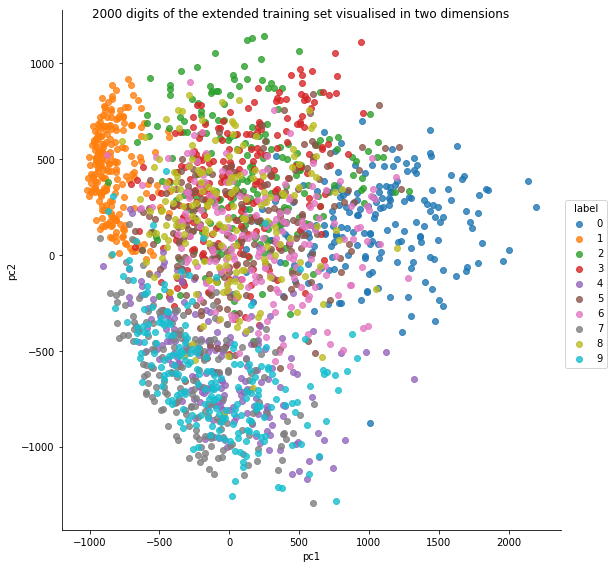

In [76]:
f = sns.lmplot("pc1", "pc2", hue='label', data=df[:2000], fit_reg=False, size=8)
plt.suptitle('2000 digits of the extended training set visualised in two dimensions')

Cool, some clustering is definitely visible!
Although the data is far from linearly separable.

Now lets find a good numer of principal components to keep.

In [78]:
pca_unbounded = PCA()

In [79]:
pca_unbounded.fit(digits_train_extended)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(1, 200)

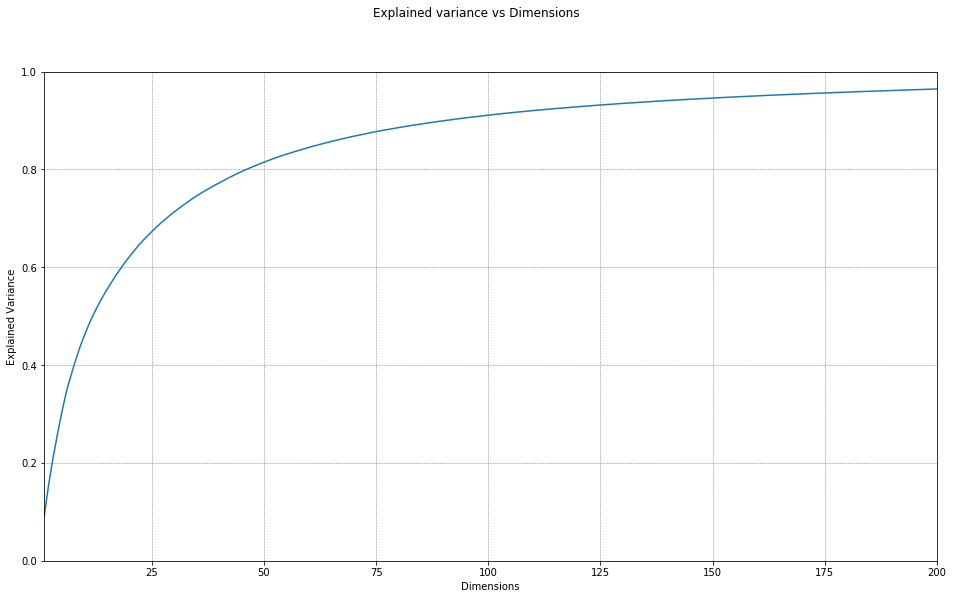

In [82]:
f, ax = plt.subplots(figsize= (16, 9))
plt.plot(np.arange(1, 201), np.cumsum(pca_unbounded.explained_variance_ratio_[:200]))
f.suptitle('Explained variance vs Dimensions')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Dimensions')
ax.grid(color='grey', linestyle='--', linewidth=.5)

ax.set_ylim([0, 1])
ax.set_xlim(1, 200)

In [96]:
explained_variance_ratio_cum = np.cumsum(pca_unbounded.explained_variance_ratio_)
for ratio in [.5, .6, .7, .8, .85, .9, .95, .99]:
    print("{} % explained variance ratio achieved with {} principal components.".format(ratio * 100, np.argmax(a >= ratio)))

50.0 % explained variance ratio achieved with 11 principal components.
60.0 % explained variance ratio achieved with 18 principal components.
70.0 % explained variance ratio achieved with 28 principal components.
80.0 % explained variance ratio achieved with 46 principal components.
85.0 % explained variance ratio achieved with 62 principal components.
90.0 % explained variance ratio achieved with 90 principal components.
95.0 % explained variance ratio achieved with 159 principal components.
99.0 % explained variance ratio achieved with 343 principal components.


Explained variance goes up quickly with the first added dimensions, and then starts tapering of. 
With 159 principal components we see 95% explained variance ratio, it does not reach 99% until we have 343 principal components.

Last time I found an explained variance ratio around 80% got me the best results.
I only evaluated with a KNN-classifier though. It could be a good idea to try some different levels this time around too.

I think 80% and 90% look like primising values. 
Both achieve a decent explained variance ratio, without using to many dimensions.

In [117]:
pca_80 = PCA(n_components=46)
pca_80.fit(digits_train_extended)

pca_90 = PCA(n_components=90)
pca_90.fit(digits_train_extended)

PCA(copy=True, iterated_power='auto', n_components=90, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# Baseline
Lets check the accuracy of my previous KNN classifier on the validation set, just to get some baseline accuracy to compare against.

In [125]:
from sklearn.neighbors import KNeighborsClassifier

In [112]:
from sklearn.metrics import accuracy_score

In [126]:
knn = KNeighborsClassifier(algorithm="brute", n_neighbors=3)
knn.fit(pca_80.transform(digits_train_extended), labels_train_extended)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Predict batches of 1 000 samples at a time to reduce stress on my laptop.

In [128]:
%time predictions = [knn.predict(pca_80.transform(digits_validation[i*1000:(i+1)*1000])) for i in range(len(digits_validation) // 1000)]

Wall time: 36.2 s


In [131]:
predictions = np.array(predictions).flatten()

In [132]:
accuracy_score(labels_validation, predictions)

0.97924999999999995

Almost 98% accuracy, pretty good!

In [279]:
with open('knn.pkl', 'wb') as f :
    pickle.dump(knn, f)

# Ensemble Learning
Ensemble learning is in essence a very simple concept.
Instead of training just one model you train many models and combine their answers.

An ensamble of identical models will not perform differently from a signle such model.
The idea is to build models with different biases, so that they can cover up each others weak spots.

I will start of with an ensamble method called bagging, that combines many models models trained using the same algorithm, but trains them on different subsets of the data.

## Bagging
The idea behind bagging is to diversify models trained with the same algorithm by training them on different subsets of the training data.

This approach makes each model more biased, but aggregating their results yields a similar bias as training on the whole training set would, but with reduced variance.

I will be opting for the famous Random Forest classifier, which combines many Descision Trees into an ensamble. 
The descision trees in the random forest are not only trained on different subsets of the training data, but also on random subsets of features.

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
random_forest_clf = RandomForestClassifier(n_estimators=500, max_depth=4, n_jobs=-1)

### 80% Explained Variance Ratio

In [118]:
%time random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 3min 10s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [119]:
predictions = random_forest_clf.predict(pca_80.transform(digits_validation))

In [120]:
accuracy_score(labels_validation, predictions)

0.76537500000000003

Ouch, 76.5% accuracy. That is disapointing. Lets see what results we get with more principal components.

### 90% Explained Variance Ratio

In [121]:
%time random_forest_clf.fit(pca_90.transform(digits_train_extended), labels_train_extended)

Wall time: 5min 36s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [122]:
predictions = random_forest_clf.predict(pca_90.transform(digits_validation))

In [123]:
accuracy_score(labels_validation, predictions)

0.77412499999999995

77.4% accuracy, barely an improvement. Lets compare these results to a single decision tree with more degrees of freedom.

### Single Decision Tree

In [133]:
from sklearn.tree import DecisionTreeClassifier

Setting max depth as 14 instead of 4 gives a maximum of 2^14 leaf nodes instead of 2^4.

In [143]:
decision_tree_clf = DecisionTreeClassifier( max_depth = 14)

In [144]:
%time decision_tree_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 26.9 s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [146]:
predictions = decision_tree_clf.predict(pca_80.transform(digits_validation))

In [147]:
accuracy_score(labels_validation, predictions)

0.85312500000000002

Okay, so a single tree allowed more complexity performs better than the ensemble of limited trees.
Lets try increasing `max_depth`, but reducing `n_estimators`. 
I will stick to using 80% explained variance ratio for now, as it seems that the regularized descision trees cannot make good use of them anyway, they are not allowed enough complexity.

### More complexity, fewer estimators

In [153]:
random_forest_clf = RandomForestClassifier(n_estimators=20, max_depth=10, n_jobs=-1)

In [154]:
%time random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 14.7 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [155]:
predictions = random_forest_clf.predict(pca_80.transform(digits_validation))

In [156]:
accuracy_score(labels_validation, predictions)

0.89324999999999999

Woho, increased accuracy! 89.3% accuracy is still far from the accuracy of my KNN-classifier, but it is a huge step up compared to my previous results with an ensamble. Training time also went down considerably, so there is room to increase both the number of estimators and their complexity. 

Any increase in `n_estimators` should never lead to overfitting, but might not increase accuracy behind a certain point if the underlying models are not complex enough.
Increasing `max_depth` will eventually lead to overfitting, but is the best tool I have to avoid underfitting the data.

Lets start by finding what `max_depth` is optimal for a single decision tree by evaluating all choices using the validation set.

In [158]:
from sklearn.base import clone

In [169]:
best_accuracy = 0
accuracies = []
# Never go past log2(m), where m is the number of samples in the training set.
for depth in range(1, int(np.ceil(np.log2(len(digits_train_extended)))) + 1):
    decision_tree_clf = DecisionTreeClassifier( max_depth = depth, max_features='auto')
    print("Training with max_depth = {}".format(depth))
    %time decision_tree_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)
    predictions = decision_tree_clf.predict(pca_80.transform(digits_validation))
    acc = accuracy_score(labels_validation, predictions)
    print("Accuracy: {}".format(round(acc*100, 3)))
    accuracies.append(acc)
    # Save the best model
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = clone(decision_tree_clf)

Training with max_depth = 1
Wall time: 1.74 s
Accuracy: 17.062
Training with max_depth = 2
Wall time: 2.06 s
Accuracy: 18.925
Training with max_depth = 3
Wall time: 2.88 s
Accuracy: 25.875
Training with max_depth = 4
Wall time: 3.46 s
Accuracy: 37.7
Training with max_depth = 5
Wall time: 3.31 s
Accuracy: 45.275
Training with max_depth = 6
Wall time: 4.23 s
Accuracy: 50.262
Training with max_depth = 7
Wall time: 5.21 s
Accuracy: 54.375
Training with max_depth = 8
Wall time: 4.21 s
Accuracy: 56.463
Training with max_depth = 9
Wall time: 4.33 s
Accuracy: 62.262
Training with max_depth = 10
Wall time: 4.88 s
Accuracy: 66.238
Training with max_depth = 11
Wall time: 4.6 s
Accuracy: 67.262
Training with max_depth = 12
Wall time: 5.15 s
Accuracy: 73.038
Training with max_depth = 13
Wall time: 5.94 s
Accuracy: 76.188
Training with max_depth = 14
Wall time: 6.27 s
Accuracy: 76.55
Training with max_depth = 15
Wall time: 6.05 s
Accuracy: 76.8
Training with max_depth = 16
Wall time: 5.87 s
Accuracy

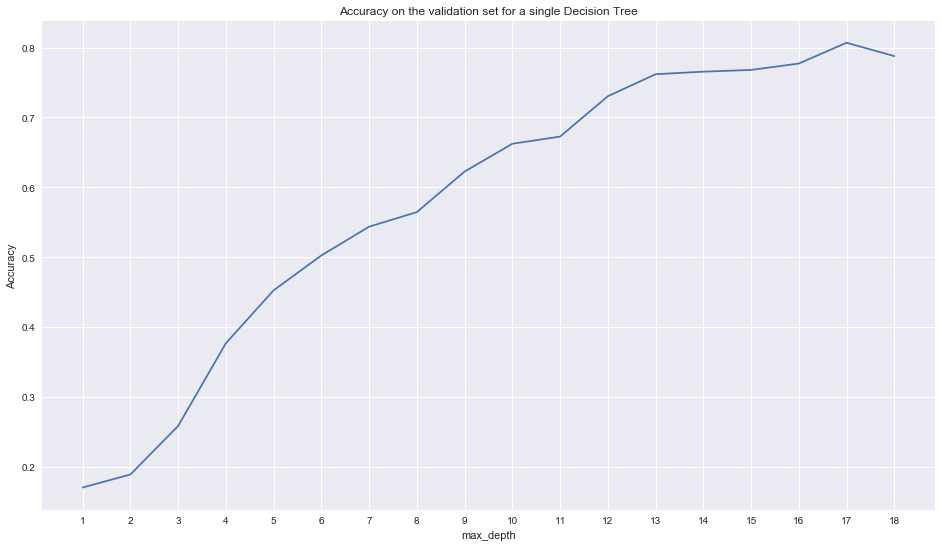

In [189]:
f, ax = plt.subplots(figsize=(16,9))

plt.plot(np.arange(1, 19), accuracies)
ax.set_ylabel('Accuracy')
ax.set_xlabel('max_depth')
ax.set_title('Accuracy on the validation set for a single Decision Tree')
plt.xticks(np.arange(1, 19));
#ax.grid(color='grey', linestyle='--', linewidth=.5)


Accuracy does not drop until `max_depth` is set to 18. 
However, accuracy is pretty stagnant from `max_depth` 13 until it goes up with `max_depth` set to 17.

Lets try two different choices of hyperparameters for Random Forest. 
* `max_depth` = 13 and as many estimators as possible.
* `max_depth` = 17 and as many estimators as possible.

#### `max_depth` = 13

In [190]:
random_forest_clf = RandomForestClassifier(n_estimators=1, max_depth=13, n_jobs=-1)

In [191]:
%time random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 3.53 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Training a single estimators takes about 3.5 seconds, so we can afford to train quite a few of them.
Lets check the accuracy of each stage by using the `warm_start` property of RandomForestClassifer.

In [198]:
random_forest_clf = RandomForestClassifier(n_estimators=1, max_depth=13, n_jobs=-1, warm_start=True)

In [204]:
accuracies = []
for estimators in range(100):
    random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)
    predictions = random_forest_clf.predict(pca_80.transform(digits_validation))
    acc = accuracy_score(labels_validation, predictions)
    random_forest_clf.n_estimators+= 1
    accuracies.append(acc)

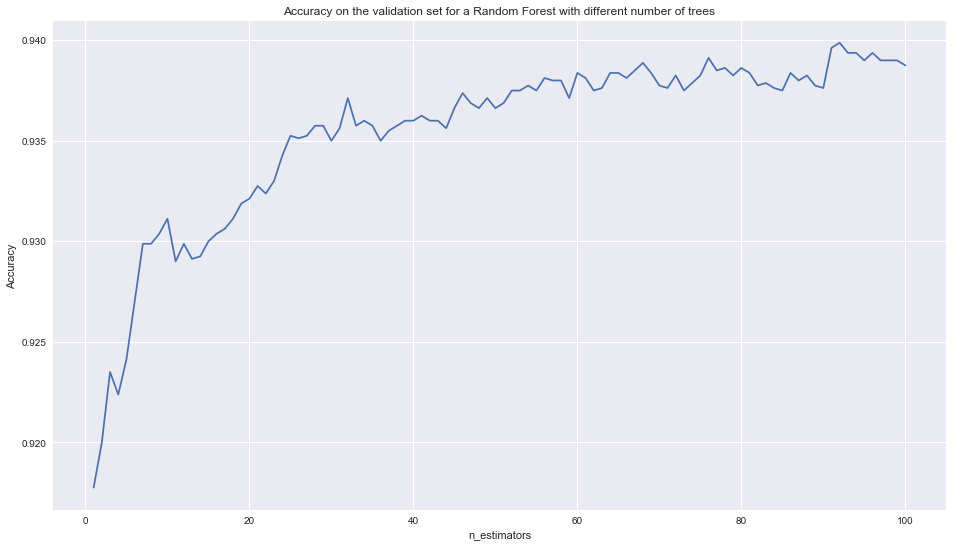

In [208]:
f, ax = plt.subplots(figsize=(16,9))

plt.plot(np.arange(1, len(accuracies)+1), accuracies)
ax.set_ylabel('Accuracy')
ax.set_xlabel('n_estimators')
ax.set_title('Accuracy on the validation set for a Random Forest with different number of trees')

In [213]:
np.argmax(accuracies) + 1

92

In [212]:
np.max(accuracies)

0.93987500000000002

Accuracy is a bit volatile with regards to the number of estimators, but for the most part seems to be increasing the more are added.
The highest accuracy achieved on the validation set was 94% with 92 estimators.

#### `max_depth` = 17

In [214]:
random_forest_clf = RandomForestClassifier(n_estimators=10, max_depth=17, n_jobs=-1)

In [215]:
%time random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 4.14 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [216]:
random_forest_clf = RandomForestClassifier(n_estimators=10, max_depth=17, n_jobs=-1, warm_start=True)

In [217]:
accuracies = []
n_estimators = [random_forest_clf.n_estimators]
for estimators in range(10):
    random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)
    predictions = random_forest_clf.predict(pca_80.transform(digits_validation))
    acc = accuracy_score(labels_validation, predictions)
    random_forest_clf.n_estimators+= 10
    n_estimators.append(random_forest_clf.n_estimators)
    accuracies.append(acc)

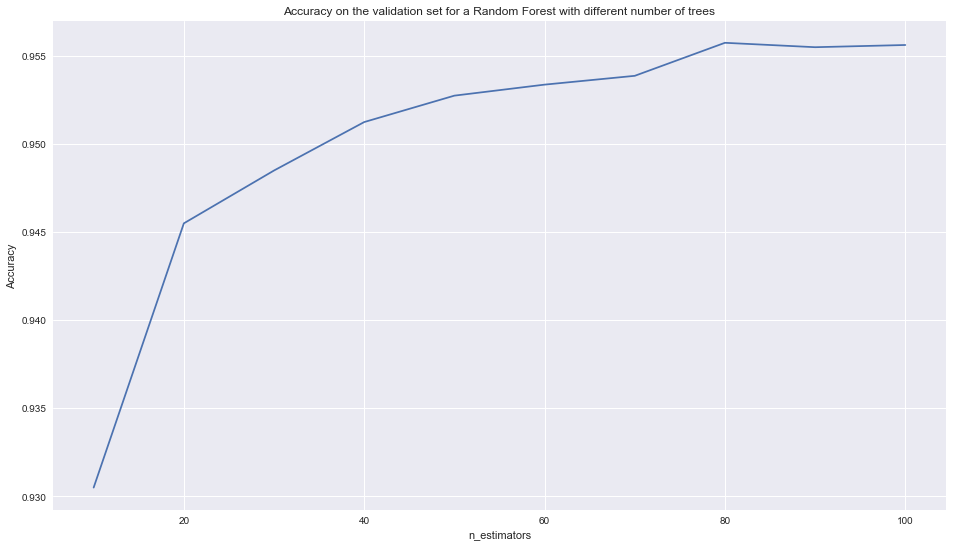

In [218]:
f, ax = plt.subplots(figsize=(16,9))

plt.plot(n_estimators[:-1], accuracies)
ax.set_ylabel('Accuracy')
ax.set_xlabel('n_estimators')
ax.set_title('Accuracy on the validation set for a Random Forest with different number of trees')

In [221]:
n_estimators[np.argmax(accuracies) ]

80

In [219]:
np.max(accuracies)

0.95574999999999999

Same trend as before, but we end up with 95.5% accuracy at 80 estimators.

I think I will let this stand as my best Random Forest result.
It does not beat the KNN-classifier, but it is quite an improvement from my first results!

In [273]:
best_random_forest_clf = RandomForestClassifier(n_estimators=80, max_depth=17, n_jobs=-1)
%time best_random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 1min 55s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [275]:
import pickle

with open('random_forest.pkl', 'wb') as f :
    pickle.dump(best_random_forest_clf, f)

### Extra Random Forest
Extra Random Forest is a variant of Random Forest that adds an extra level of randomness.

A Random Forest chooses a random subset of features for each node, and then sets a threshold optimising some loss function.
An Extra Random Forest sets this threshold randomly, this makes the trees more biased but with less variance, it also makes them very fast to train.
Lets see how an Extra Random Forest compares to my best Random Forest.

In [223]:
from sklearn.ensemble import ExtraTreesClassifier

In [234]:
extra_forest_clf = ExtraTreesClassifier(n_estimators=10, max_depth=17, n_jobs=-1, warm_start=True)

In [235]:
accuracies = []
n_estimators = []
for estimators in range(15):
    extra_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)
    predictions = extra_forest_clf.predict(pca_80.transform(digits_validation))
    acc = accuracy_score(labels_validation, predictions)
    n_estimators.append(extra_forest_clf.n_estimators)
    extra_forest_clf.n_estimators+= 10
    accuracies.append(acc)

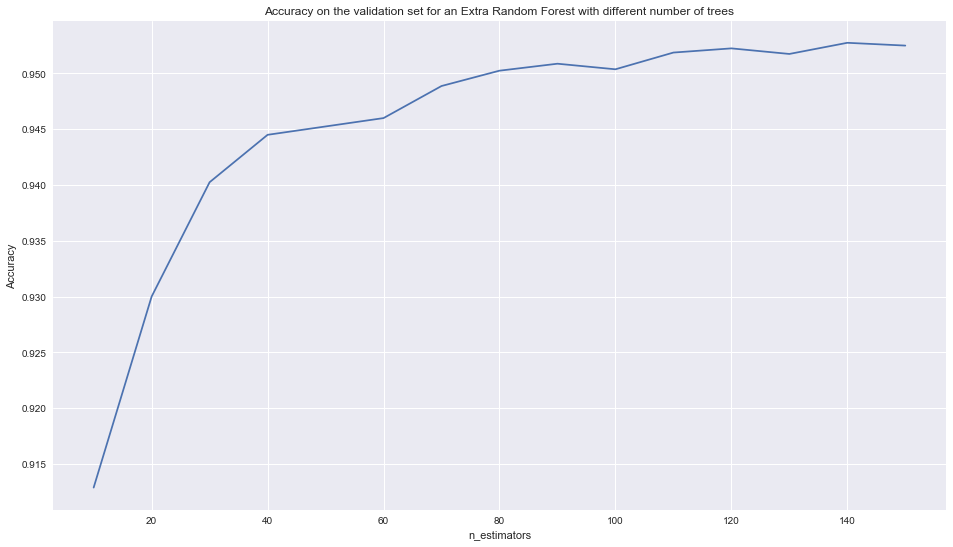

In [236]:
f, ax = plt.subplots(figsize=(16,9))

plt.plot(n_estimators, accuracies)
ax.set_ylabel('Accuracy')
ax.set_xlabel('n_estimators')
ax.set_title('Accuracy on the validation set for an Extra Random Forest with different number of trees')

In [237]:
n_estimators[np.argmax(accuracies) ]

140

In [238]:
np.max(accuracies)

0.95274999999999999

Similar results as the Random Forest!

In [276]:
best_extra_random_forest_clf = ExtraTreesClassifier(n_estimators=140, max_depth=17, n_jobs=-1)
%time best_extra_random_forest_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 46.8 s


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=17, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [277]:
with open('extra_random_forest.pkl', 'wb') as f :
    pickle.dump(best_extra_random_forest_clf, f)

## Boosting
Lets try another approach to ensamble learning, boosting.
Boosting build on the idea of training models sequentially, with each model trying to correct its predecessor.

I will be using a boosting method called AdaBoost, which adapts the weights of each training instance based on the errors of its predecessor.

### AdaBoost
AdaBoost trains weak classifiers sequentially, and updates the weight of each training sample based on the errors of the previous classifier.

In [246]:
from sklearn.ensemble import AdaBoostClassifier

In [261]:
ada_clf = AdaBoostClassifier(n_estimators=100, base_estimator=DecisionTreeClassifier(max_depth=8), learning_rate=.5, algorithm="SAMME.R")

In [262]:
%time ada_clf.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 30min 7s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=None)

In [263]:
predictions = ada_clf.predict(pca_80.transform(digits_validation))

In [264]:
accuracy_score(labels_validation, predictions)

0.90637500000000004

Long training time and poor results. I should probably have opted for a more complex model with fewer estimators.

In [266]:
ada_clf2 = AdaBoostClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(max_depth=17), learning_rate=.5, algorithm="SAMME.R")

In [267]:
%time ada_clf2.fit(pca_80.transform(digits_train_extended), labels_train_extended)

Wall time: 6min 47s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=10, random_state=None)

In [268]:
predictions = ada_clf2.predict(pca_80.transform(digits_validation))

In [269]:
accuracy_score(labels_validation, predictions)

0.91925000000000001

Better result with lower training time. 
I could probably increase `n_estimators` a bit more, but I don't feel like waiting for more training.
KNN and Random Forest both performed better with less training time.

In [313]:
best_ada_clf = ada_clf2

In [314]:
with open('ada_boost.pkl', 'wb') as f :
    pickle.dump(best_ada_clf, f)

## Combining my classifiers
I have trained some pretty different classifiers. Lets see what happens if I combine them! 

Comments on the classifiers:
* KNN - Classifier
    * ~98% Accuracy, the best by far
* Random Forest
    * ~95.5% Accuracy
* Extra Random Forest
    * ~95% Accuracy, model could be pretty similar to the RandomForest model, might not be a good idea to include
* AdaBoost
    * ~92% Accuracy, the worst model of the bunch. Lets see if it contributes anything in an ensamble!
    
All models are able to predict probabilities, so weak voting can be used!

sklearns Voting Classifier does not handle pre fitted models. Lets implement a simple voting classifier.

In [317]:
from sklearn.base import ClassifierMixin, TransformerMixin

In [318]:
# Inspired by:
# https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/voting_classifier.py
class SimpleVotingClassifier(ClassifierMixin, TransformerMixin):
    def __init__(self, estimators, labels, voting='soft'):
        self.estimators = estimators
        self.voting = voting
        self.labels = labels
        
    def predict(self, X):
        if self.voting == "soft":
            result = np.argmax(self.predict_proba(X), axis=1)
        else:
            # Not supported yet
            pass
        return np.asarray([self.labels[i] for i in result])
        
            
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.estimators])
        return np.average(probas, axis=0)
        

### AdaBoost + RandomForest + KNN

In [319]:
voting_clf = SimpleVotingClassifier(
        estimators = [knn, best_random_forest_clf, best_ada_clf],
        labels = knn.classes_,
        voting = 'soft'
        
)

In [325]:
%time predictions = np.asarray([voting_clf.predict(pca_80.transform(digits_validation[i*1000:(i+1)*1000])) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 43.2 s


In [329]:
accuracy_score(labels_validation, predictions)

0.96825000000000006

Better than both AdaBoost and RandomForest, but worse than KNN.

### Random Forest + Extra Forest + KNN

In [330]:
voting_clf = SimpleVotingClassifier(
        estimators = [knn, best_random_forest_clf, extra_forest_clf],
        labels = knn.classes_,
        voting = 'soft'
        
)

In [331]:
%time predictions = np.asarray([voting_clf.predict(pca_80.transform(digits_validation[i*1000:(i+1)*1000])) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 46 s


In [332]:
accuracy_score(labels_validation, predictions)

0.97912500000000002

Even better, but still not as good as the KNN-classifier.

### Random Forest + KNN
Lets try just our two best classifiers. With hard voting it would make no sense to combine just two classifier, but with soft voting it could help.

In [333]:
voting_clf = SimpleVotingClassifier(
        estimators = [knn, best_random_forest_clf],
        labels = knn.classes_,
        voting = 'soft'
        
)

In [334]:
%time predictions = np.asarray([voting_clf.predict(pca_80.transform(digits_validation[i*1000:(i+1)*1000])) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 50 s


In [335]:
accuracy_score(labels_validation, predictions)

0.97950000000000004

Very similar to what the KNN achieves on its own. 
I wonder if the KNN predicts higher probabilities than the Random Forest, and therefore dominates all votes?

In [336]:
%time knn_predictions = np.asarray([knn.predict(pca_80.transform(digits_validation[i*1000:(i+1)*1000])) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 44 s


In [338]:
%time rand_forest_predictions = np.asarray([best_random_forest_clf.predict(pca_80.transform(digits_validation[i*1000:(i+1)*1000])) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 900 ms


In [337]:
accuracy_score(predictions, knn_predictions)

0.99662499999999998

In 99.7% of all cases the knn classifier agrees with the choice of the voting classifier.

In [340]:
accuracy_score(knn_predictions, rand_forest_predictions)

0.95550000000000002

In 95.6 % of all cases the KNN-classifier and the Random Forest Classifier agree.

In [372]:
%time knn_probas = np.asarray([knn.predict_proba(pca_80.transform(digits_validation[i*1000:(i+1)*1000])).max(axis=1) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 46.9 s


In [373]:
%time random_forest_probas = np.asarray([best_random_forest_clf.predict_proba(pca_80.transform(digits_validation[i*1000:(i+1)*1000])).max(axis=1) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 965 ms


In [374]:
df = pd.DataFrame(columns = ['label', 'knn_pred', 'knn_proba', 'rand_forest_pred', 'rand_forest_proba', 'vote_pred'], data=np.asarray([labels_validation, knn_predictions, knn_probas, rand_forest_predictions, random_forest_probas, predictions]).T)

In [359]:
len(df[(df['knn_pred'] != df['rand_forest_pred'])])

356

In [358]:
len(df[(df['knn_pred'] != df['rand_forest_pred']) & (df['vote_pred'] == df['rand_forest_pred'])])

25

The Random Forest got to overrule the KNN-classifier in 25 votes out of 356 disagreements.

In [377]:
len(df[(df['knn_pred'] != df['rand_forest_pred']) & (df['rand_forest_pred'] == df['label'])])

57

Out of the 356 disagreements the Random Forest was right in 57 cases. So often it is good that the voting classifier chooses the vote of the KNN-classifier.

I suspect that it is not really fair to compare the probabilities of a KNN-classifier with just 3 neighbours and the RandomForest though. 
The KNN-classifier will always predict a probability of either 1/3, 2/3 or 3/3 for its winning choice, which gives the Random Forest quite arbitrary probabilities to beat if it is going to overrule the KNN-classifier. Lets have a look at how certain the two classifiers are of their different votes.

In [390]:
bins_forest = np.histogram(df['rand_forest_proba'], bins = np.arange(0, 1.1, .1))
bins_knn = np.histogram(df['knn_proba'], bins = np.arange(0, 1.1, .1))

In [407]:
bins = ['{}-{}%'.format(int(i*100), int((i+.1)*100)) for i in np.arange(0, 1, .1)]

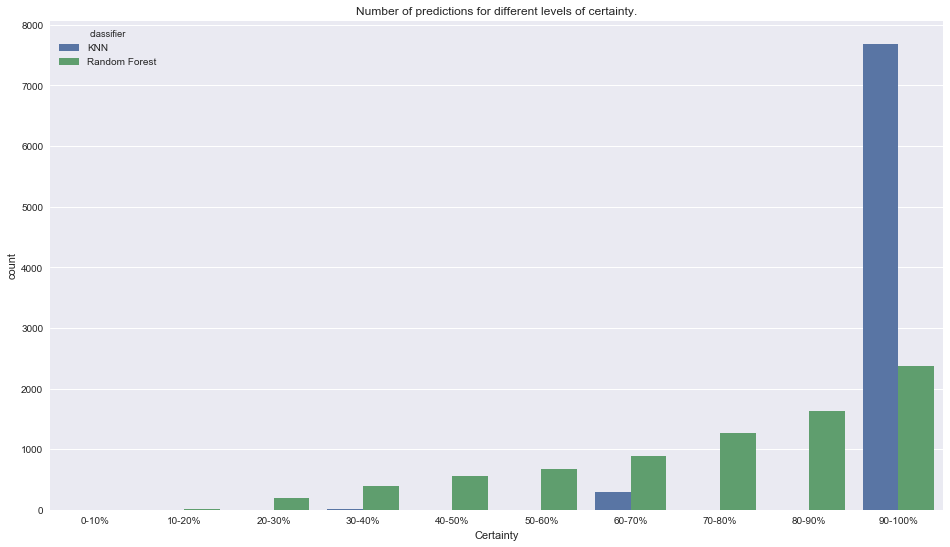

In [414]:
f, ax = plt.subplots(figsize=(16,9))

knn_df = pd.DataFrame(columns=['Certainty', 'count'], data = np.asarray([bins, bins_knn[0]]).T)
knn_df['classifier'] = 'KNN'
rand_forest_df = pd.DataFrame(columns=['Certainty', 'count'], data = np.asarray([bins, bins_forest[0]]).T)
rand_forest_df['classifier'] = 'Random Forest'

df = pd.concat([knn_df, rand_forest_df])
df['count'] = df['count'].astype(int)

sns.barplot(x='Certainty', y='count', hue='classifier', data=df, ax=ax)
ax.set_title('Number of predictions for different levels of certainty.')

The KNN-classifier is almost always 100% confident in its choice, giving the Random Forest Classifier no room to overrule the decision in these cases.

Lets try another value of K for the KNN classifier!

### More neighbours!
In my earlier results 3 neighbours prove optimal.
Adding more neighbours gives weight to training samples further away from the instance being classified.
This potentially makes the classifier less certain of what the best choice is, maybe this is a good thing in combination with the Random Forest, that will be able to assist with choices when the KNN does not feel certain.

In [417]:
knn4 = KNeighborsClassifier(algorithm="brute", n_neighbors=4)
knn4.fit(pca_80.transform(digits_train_extended), labels_train_extended)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [418]:
voting_clf = SimpleVotingClassifier(
        estimators = [knn4, best_random_forest_clf],
        labels = knn4.classes_,
        voting = 'soft'
        
)

In [419]:
%time predictions = np.asarray([voting_clf.predict(pca_80.transform(digits_validation[i*1000:(i+1)*1000])) for i in range(len(digits_validation) // 1000)]).flatten()

Wall time: 1min 3s


In [420]:
accuracy_score(labels_validation, predictions)

0.97899999999999998

Hmm, lower accuracy, but only by a little. 
More neighbours means less variance, so maybe this model will generalise better on the test set. Lets try this one on the test set.

In [432]:
%time predictions = np.asarray([voting_clf.predict(pca_80.transform(digits_test[i*1000:(i+1)*1000])) for i in range(len(digits_test) // 1000)]).flatten()

Wall time: 3min 15s


In [434]:
submission_df = pd.DataFrame(list(zip(np.arange(1, 28001), predictions)), columns = ['ImageID', 'Label'])
submission_df.set_index('ImageID').to_csv('Submissions/submission8.csv')

98.2% accuracy, not an improvement over the KNN classifier.
Of course, in one way I am at a dissadvantage this time as I set aside a validation set, but at the same time this should help me build a model that generalises better.

# Summary
Playing around with ensemble methods has been very exciting.
I am especially happy about finding a decent set of hyper parameters for Random Forest, as it performed so increadibly poorly with default parameters.

When combining classifiers using a Voting Classifier it is important to consider how the different classifiers estimate probabilities.
In my case, using a KNN-Classifier with k=3 and a Random Forest, it turned out that the RandomForest seldom reported higher confidence in its top choice compared to the KNN classifier which most of the time just estimated a 100% certainty.